<a href="https://colab.research.google.com/github/RMhanovernorwichschools/neural_network_prac/blob/master/Binary_discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
#note that imported data comes from tensorflow for now. Will need to look into how to import own data.

17465344/17464789 [==============================] - 0s 0us/step


In [2]:
print("Training entries: {0}, labels: {1}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [3]:
# A python dictionary mapping words to an integer index (should be usable in future)
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
#the above add some integers corresponding to relevant outputs which aren't words

#dictionary.items() gives a list version of the dictionary (which allows for reformatting into a different dictionary with same "items")
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
#returns a dictionary from a list made from a dictionary

def decode(text):
    return ' '.join([reverse_word_index.get(i, '') for i in text])
    #"s.join(l)" command adds items of l together with x as "glue" between them
    #get for i in text returns the word corresponding to the integers or '' if there isn't a corresponding word

1646592/1641221 [==============================] - 0s 0us/step


In [4]:
#showing how "decode" works
decode(train_data[30])

"<START> i caught this at a test screening all i can say is what the hell this movie plays out about as smoothly as mickey mouse reading the script for scarface it's bizarre beyond making the slightest bit of sense and even if you do leave your brain in the car the film is still so bizarre that it isn't even funny br br the plot involves crocodile hunter steve irwin trying to save a crocodile which contains a cia <UNK> the cia comes after irwin to get their <UNK> back irwin mistakes them for <UNK> and sets out to stop them br br that's about all the story there is the rest is over the top <UNK> of australian culture <UNK> see <UNK> and <UNK> and strangely choreographed action sequences at one point irwin <UNK> a <UNK> <UNK> and knife fights with a cia agent on top of it yes that's right steve irwin knife fights a guy on top of an <UNK> let that be your guide for this ridiculously bad film"

There is an issue in figuring out how to converts these integer-words into 0s and 1s. This is solved here with the following:

- The arrays are padded to have the same length (currently some reviews longer than others)
- Tensors will be in shape (max_length, num_reviews) and handled by an embedding layer

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=2494)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=2494)

In [6]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))   #considering that there are 10,000 (1st argument) possible words, create 16 (2nd argument) nodes
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))    #just a layer weighing all of last nodes
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))  #only one output, so only one node, and sigmoid so it's a value from 0 to 1

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


*Embedding* makes 16 (argument 2) nodes out of the input by weighing the presence/absence for each word which is possible (argument 1) for each. 
Imagine, for example, that "super" is \*1 for passionate, \*0.6 for good, \*0 for bored, etc.

*Global_Average_Pooling_1D*  adjusts for length by essentially averaging out values. The embedded nodes will be higher with more words, but, because we're trying to figure this out based on concentration of words, this effect needs to be cancelled out.

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
#'adam' is same as used in tensorflow_basics
#'binary_crossentropy' is good for loss b/c it's just one output for *probability* (so from 0 to 1)
#metric is same as that used in tensorflow_basics

x_val = train_data[:10000]             #this takes the first 10,000 inputs (those before [10000])
partial_x_train = train_data[10000:]   #this takes the inputs 10,000 and after

#does the same for the labels (intended outputs)
y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [8]:
#by specifying "history =" we save the session so it can be reviewed
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

#that was training for 40 epochs. Now we can see how it does against the test data.
results = model.evaluate(test_data, test_labels)
print(results)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 6s 367us/sample - loss: 0.6931 - acc: 0.5036 - val_loss: 0.6931 - val_acc: 0.4947
Epoch 2/40
15000/15000 [==============================] - 5s 332us/sample - loss: 0.6929 - acc: 0.5091 - val_loss: 0.6928 - val_acc: 0.4995
Epoch 3/40
15000/15000 [==============================] - 5s 331us/sample - loss: 0.6925 - acc: 0.5101 - val_loss: 0.6924 - val_acc: 0.5227
Epoch 4/40
15000/15000 [==============================] - 5s 332us/sample - loss: 0.6921 - acc: 0.5211 - val_loss: 0.6917 - val_acc: 0.6249
Epoch 5/40
15000/15000 [==============================] - 5s 331us/sample - loss: 0.6912 - acc: 0.5630 - val_loss: 0.6908 - val_acc: 0.5677
Epoch 6/40
15000/15000 [==============================] - 5s 330us/sample - loss: 0.6895 - acc: 0.6182 - val_loss: 0.6893 - val_acc: 0.5192
Epoch 7/40
15000/15000 [==============================] - 5s 3

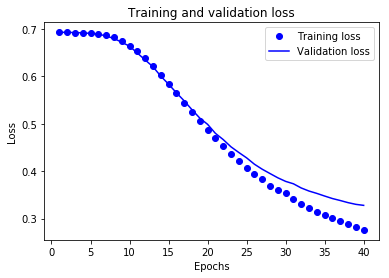

In [9]:
#below shows some of loss over time using history, to help give a sense of what happened (and how to improve)
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
#shows "keys" (areas/types of data) labels from history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

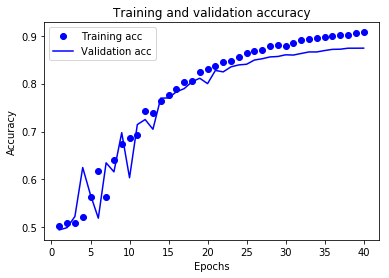

In [11]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [0]:
def encode(text):
  a=text.split()
  return [1]+[word_index.get(i, 2) for i in a]

In [24]:
#negative is 0 and positive is 1
example = "i though the character development was intriguing and some of the plot twists had me on the edge of my seat the villain was horrifying and overall the suspense really got to you"
inp = [encode(example)]
inp = keras.preprocessing.sequence.pad_sequences(inp,
                                                 value=word_index["<PAD>"],
                                                 padding='post',
                                                 maxlen=2494)
ans = model.predict(inp)
print(ans[0])

[0.5810319]
